# Video Conversion & Analysis

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook converts videos into a data structure for use in other notebooks. Given a folder of videos, store the coordinates of each video frame in a data structure for later analysis (see output). Further, some data analysis of the videos are done.

INPUT: video folder

OUTPUT: list of tuples with the form - (label, [ {'frames': frame_number (int), 'coordinates': {x1, y1.,..(all the keypoints)} }])

## TOC:
0. [Setup](#0.-Import-Libraries-&-Setup)
1. [Capture & Store Frames in DS](#1.-Capture-&-Store-Frames)
2. [Save & Load DS From Local Storage](#2.-Save-&-Load-Frames)
3. [Visualise Data](#3.-Visualise-Data)

# 0. Import Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import cv2
import mediapipe as mp

import math

import os

from sklearn.model_selection import train_test_split

import pickle

# 1. Capture & Store Frames

In [2]:
all_landmarks = [] # List of dictionaries storing all the landmarks

def label_landmarks(frame_number, landmarks):
    unboxed_landmarks = {}

    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append({ 'frame': frame_number, 'coordinates': unboxed_landmarks })

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

all_videos = [] # list of tuples - get the label from the file

directory = os.fsencode('squat-videos') # Folder of videos

exit = False

for file in os.listdir(directory):
    frame_count = 1
    filename = os.fsdecode(file)
    cap = cv2.VideoCapture('squat-videos/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            k = cv2.waitKey(1)
            if results.pose_landmarks != None:
                label_landmarks(frame_count, results.pose_landmarks) # store the landmarks frame by frame
                frame_count += 1
                
            if cv2.waitKey(10) & 0xFF == ord('q'):
                exit = True
                break

            cv2.imshow("output", image)

        cap.release()
        cv2.destroyAllWindows()
        
        name = None
        
        if 'good' in filename:
            name = 'good'
        elif 'parallel' in filename:
            name = 'parallel'
        elif 'leaning' in filename:
            name = 'leaning'
        
        # Save the list of frames to coordinates in all_videos and then go onto next video
        tup = (name, all_landmarks.copy())
        all_videos.append(tup)
        all_landmarks.clear()
        if exit == True:
            break

# 2. Save & Load Frames

In [4]:
pickle.dump(all_videos, open('all-squats.dump', 'wb'))

In [5]:
all_videos = pickle.load(open('all-squats.dump', 'rb'))
print(len(all_videos))

90


# 3. Visualise Data

In [6]:
# The list we want to convert has format: [{'frame': num, 'coordinates': {'x1'...'z33'}}]
# INPUT: list of the frames to coordinates for one video
# OUTPUT: DataFrame of the list
def convert_list_to_df(list_to_convert):
    d = {'frame': []}
    for i in range(33):
        d['x' +  str(i)] = []
        d['y' +  str(i)] = []
        d['z' +  str(i)] = []
    
    for frame in list_to_convert:
        d['frame'].append(frame['frame'])
        for j in range(33):
            d['x' +  str(j)].append(frame['coordinates']['x' + str(j)])
            d['y' +  str(j)].append(frame['coordinates']['y' + str(j)])
            d['z' +  str(j)].append(frame['coordinates']['z' + str(j)])
    return d

Lets set aside the videos for training and testing so we can spot trends in just the training set. The same seed (random_state value) is used in f1-gen-heuristic notebook so the corresponding testing set is created.

In [7]:
all_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)
print(len(all_videos))

60


Now, lets take 3 examples from the training dataset. A good example, an example that does not go parallel and an example where I am leaning forwards during the movement.

In [8]:
# Display what video is at each index
for i in range(len(all_videos)):
    print(str(i) + '. ' +  all_videos[i][0])

0. good
1. parallel
2. good
3. leaning
4. leaning
5. good
6. leaning
7. leaning
8. good
9. parallel
10. good
11. good
12. parallel
13. good
14. leaning
15. good
16. good
17. good
18. good
19. leaning
20. good
21. parallel
22. good
23. parallel
24. leaning
25. parallel
26. parallel
27. leaning
28. leaning
29. leaning
30. leaning
31. leaning
32. parallel
33. good
34. parallel
35. leaning
36. leaning
37. leaning
38. parallel
39. leaning
40. good
41. parallel
42. leaning
43. parallel
44. parallel
45. leaning
46. good
47. good
48. leaning
49. good
50. good
51. good
52. parallel
53. parallel
54. parallel
55. good
56. leaning
57. parallel
58. good
59. leaning


In [9]:
df_parallel = pd.DataFrame(convert_list_to_df(all_videos[1][1]))
all_videos[1][0]

'parallel'

In [10]:
df_good = pd.DataFrame(convert_list_to_df(all_videos[33][1]))
all_videos[33][0]

'good'

In [11]:
df_leaning = pd.DataFrame(convert_list_to_df(all_videos[45][1]))
all_videos[45][0]

'leaning'

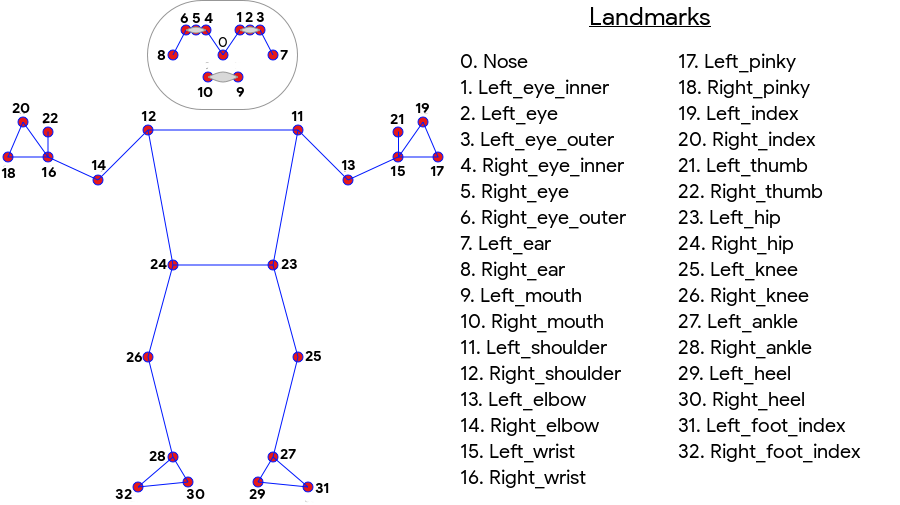

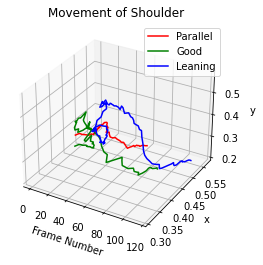

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(df_parallel.frame, df_parallel.x11, df_parallel.y11, 'red')
ax.plot3D(df_good.frame, df_good.x11, df_good.y11, 'green')
ax.plot3D(df_leaning.frame, df_leaning.x11, df_leaning.y11, 'blue')
ax.legend(['Parallel', 'Good', 'Leaning'])
ax.set_title('Movement of Shoulder')
ax.set_xlabel('Frame Number')
ax.set_ylabel('x')
ax.set_zlabel('y')
plt.show()

Figure shows the movement of the shoulder coordinate in each frame. Hard to tell much from this graph.

In [13]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [14]:
def get_angle_diff(frame, keypoint_1, keypoint_2, keypoint_3, keypoint_4, keypoint_5, keypoint_6):
    return abs(get_angle(frame, keypoint_1, keypoint_2, keypoint_3) - get_angle(frame, keypoint_4, keypoint_5, keypoint_6))

In [15]:
# Get the y differnece between two keypoints in a frame
# INPUT: frame (dictionary of keypoints to coordinates) and the 2 keypoints
# OUPUT: absolute value of the difference
def get_y_difference(frame, keypoint_1, keypoint_2):
    return abs(frame['y'+str(keypoint_1)] - frame['y'+str(keypoint_2)])

In [16]:
df_parallel['knee_hip_difference'] = df_parallel.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
df_parallel[['frame', 'knee_hip_difference']]

,frame,knee_hip_difference
0,1,0.157290
1,2,0.159024
2,3,0.160151
3,4,0.160081
4,5,0.159371
...,...,...
66,67,0.153048
67,68,0.153693
68,69,0.153527
69,70,0.153529


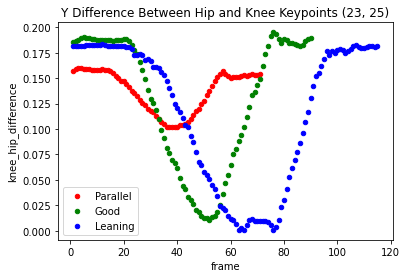

In [17]:
ax = df_parallel.plot(kind='scatter', x='frame', y='knee_hip_difference', color='red')

df_good['knee_hip_difference'] = df_good.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
df_good.plot(ax=ax, kind='scatter', x='frame', y='knee_hip_difference', color='green')

df_leaning['knee_hip_difference'] = df_leaning.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
df_leaning.plot(ax=ax, kind='scatter', x='frame', y='knee_hip_difference', color='blue')

ax.set_title("Y Difference Between Hip and Knee Keypoints (23, 25)")
ax.legend(['Parallel', 'Good', 'Leaning'])

plt.savefig('s-hip-knee-diff.svg', bbox_inches='tight')
plt.show()

The minima of the red curve is a lot less than the minima of the others. This indicates the squat was not parallel.

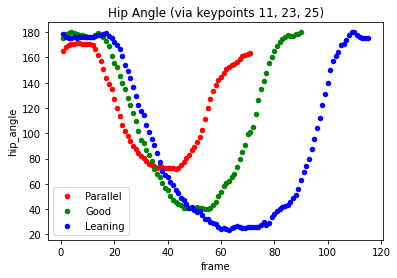

In [18]:
df_parallel['hip_angle'] = df_parallel.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
ax = df_parallel.plot(kind='scatter', x='frame', y='hip_angle', color='red')

df_good['hip_angle'] = df_good.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
df_good.plot(ax=ax, kind='scatter', x='frame', y='hip_angle', color='green')

df_leaning['hip_angle'] = df_leaning.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
df_leaning.plot(ax=ax, kind='scatter', x='frame', y='hip_angle', color='blue')

ax.set_title("Hip Angle (via keypoints 11, 23, 25)")
ax.legend(['Parallel', 'Good', 'Leaning'])

plt.show()

All graphs follow a similar shape, however the minima of the blue curve is significantly less. This indicates when someone is leaning orward in the squat the hip angle dips bellow 40 degrees.

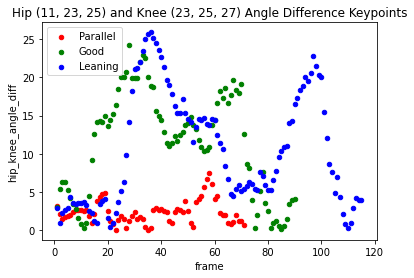

In [19]:
df_parallel['hip_knee_angle_diff'] = df_parallel.apply(lambda row: get_angle_diff(row, 11, 23, 25, 23, 25, 27), axis=1)
ax = df_parallel.plot(kind='scatter', x='frame', y='hip_knee_angle_diff', color='red')

df_good['hip_knee_angle_diff'] = df_good.apply(lambda row: get_angle_diff(row, 11, 23, 25, 23, 25, 27), axis=1)
df_good.plot(ax=ax, kind='scatter', x='frame', y='hip_knee_angle_diff', color='green')

df_leaning['hip_knee_angle_diff'] = df_leaning.apply(lambda row: get_angle_diff(row, 11, 23, 25, 23, 25, 27), axis=1)
df_leaning.plot(ax=ax, kind='scatter', x='frame', y='hip_knee_angle_diff', color='blue')

ax.set_title("Hip (11, 23, 25) and Knee (23, 25, 27) Angle Difference Keypoints")
ax.legend(['Parallel', 'Good', 'Leaning'])

plt.show()

Not any useful information from this graph.

Lets check if this pattern continues in all the training dataset videos.

In [20]:
parallel_dfs = []
leaning_dfs = []
good_dfs = []

for vid in all_videos:
    if vid[0] == 'parallel':
        parallel_dfs.append(pd.DataFrame(convert_list_to_df(vid[1])))
    elif vid[0] == 'leaning':
        leaning_dfs.append(pd.DataFrame(convert_list_to_df(vid[1])))
    else:
        good_dfs.append(pd.DataFrame(convert_list_to_df(vid[1])))

In [21]:
df_parallel_concat = pd.concat(parallel_dfs)
df_leaning_concat = pd.concat(leaning_dfs)
df_good_concat = pd.concat(good_dfs)

df_parallel_means = (df_parallel_concat.groupby(df_parallel_concat.frame)).mean()
df_leaning_means = (df_leaning_concat.groupby(df_leaning_concat.frame)).mean()
df_good_means = (df_good_concat.groupby(df_good_concat.frame)).mean()

In [22]:
df_good_means

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
frame,,,,,,,,,,,,,,,,,,,,,
1,0.347711,0.162546,-0.124947,0.356503,0.145119,-0.180931,0.361781,0.145162,-0.180971,0.366261,...,-0.108574,0.528653,0.751991,0.660129,0.377813,0.840288,-0.284272,0.401414,0.757343,0.598782
2,0.346140,0.162460,-0.142905,0.356665,0.145493,-0.199949,0.361477,0.145272,-0.199961,0.365930,...,-0.090840,0.527711,0.753165,0.698105,0.377885,0.840400,-0.276090,0.402131,0.757341,0.634352
3,0.344522,0.160399,-0.161474,0.355770,0.143711,-0.218088,0.360692,0.143533,-0.218099,0.365323,...,-0.066278,0.527200,0.753312,0.719987,0.378303,0.840353,-0.256422,0.402772,0.757728,0.655687
4,0.344143,0.160339,-0.165227,0.355333,0.143636,-0.222102,0.360496,0.143560,-0.222103,0.365261,...,-0.080776,0.526733,0.752919,0.736186,0.378087,0.840352,-0.272145,0.402966,0.757895,0.674634
5,0.344508,0.160873,-0.166291,0.355224,0.144533,-0.223580,0.360421,0.144483,-0.223572,0.365417,...,-0.095121,0.525920,0.751998,0.736195,0.378140,0.840317,-0.288965,0.403096,0.758969,0.673505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.319628,0.203290,-0.077948,0.326912,0.187229,-0.118650,0.332739,0.186139,-0.118686,0.338926,...,-0.204135,0.541396,0.752468,0.379551,0.383631,0.798249,-0.391758,0.419262,0.746756,0.274684
127,0.320939,0.204074,-0.084030,0.328139,0.188228,-0.124695,0.333901,0.187164,-0.124739,0.340036,...,-0.187843,0.539937,0.753195,0.407426,0.383259,0.798831,-0.382957,0.419445,0.747463,0.299086
128,0.332417,0.216824,-0.045615,0.339478,0.201364,-0.085418,0.345107,0.199983,-0.085479,0.351050,...,-0.156055,0.534476,0.772490,0.322117,0.367163,0.813724,-0.341091,0.411754,0.762932,0.201346


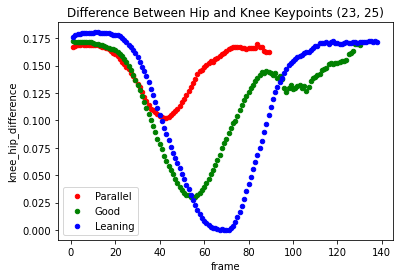

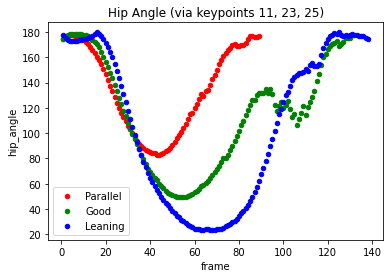

In [23]:
# Plot the y difference beteween the knee and hip
df_parallel_means['knee_hip_difference'] = df_parallel_means.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
ax = df_parallel_means.reset_index().plot(kind='scatter', x='frame', y='knee_hip_difference', color='red')

df_good_means['knee_hip_difference'] = df_good_means.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
df_good_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y='knee_hip_difference', color='green')

df_leaning_means['knee_hip_difference'] = df_leaning_means.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
df_leaning_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y='knee_hip_difference', color='blue')

ax.set_title("Difference Between Hip and Knee Keypoints (23, 25)")
ax.legend(['Parallel', 'Good', 'Leaning'])

# Plot the hip angle for the means
df_parallel_means['hip_angle'] = df_parallel_means.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
ax2 = df_parallel_means.reset_index().plot(kind='scatter', x='frame', y='hip_angle', color='red')

df_good_means['hip_angle'] = df_good_means.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
df_good_means.reset_index().plot(ax=ax2, kind='scatter', x='frame', y='hip_angle', color='green')

df_leaning_means['hip_angle'] = df_leaning_means.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
df_leaning_means.reset_index().plot(ax=ax2, kind='scatter', x='frame', y='hip_angle', color='blue')

ax2.set_title("Hip Angle (via keypoints 11, 23, 25)")
ax2.legend(['Parallel', 'Good', 'Leaning'])

plt.savefig('s-hip-means.svg', bbox_inches='tight')

# df_parallel_means['hip_knee_angle_diff'] = df_parallel_means.apply(lambda row: get_angle_diff(row, 11, 23, 25, 23, 25, 27), axis=1)
# ax3 = df_parallel_means.reset_index().plot(kind='scatter', x='frame', y='hip_knee_angle_diff', color='red')

# df_good_means['hip_knee_angle_diff'] = df_good_means.apply(lambda row: get_angle_diff(row, 11, 23, 25, 23, 25, 27), axis=1)
# df_good_means.reset_index().plot(ax=ax3, kind='scatter', x='frame', y='hip_knee_angle_diff', color='green')

# df_leaning_means['hip_knee_angle_diff'] = df_leaning_means.apply(lambda row: get_angle_diff(row, 11, 23, 25, 23, 25, 27), axis=1)
# df_leaning_means.reset_index().plot(ax=ax3, kind='scatter', x='frame', y='hip_knee_angle_diff', color='blue')

# ax3.set_title("Hip (11, 23, 25) and Knee (23, 25, 27) Angle Difference Keypoints")
# ax3.legend(['Parallel', 'Good', 'Leaning'])

plt.show()

The pattern is even clearer now. We can also see the length of the exercise varies. When you do not go low enough or reach parallel in a squat, the length of the exercise tends to be shorter. This is why the red curve is shorter in terms of number of frames as compared to the other curves.